In [1]:
# Main libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ETL libraries
from ETL import ETL

# Scikit-learn: Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Scikit-learn: Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Scikit-learn: Testing and evaluation
from sklearn.metrics import (
    accuracy_score, 
    auc, 
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_curve
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split


In [2]:
df = pd.read_csv('dataset/flights.csv')

In [3]:
df = ETL(df)

In [12]:
df.columns

Index(['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'DEP_DELAY',
       'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'ACT_TO_CRS_RATIO', 'FL_MON', 'FL_DAY', 'FL_YEAR', 'FL_DOW',
       'CRS_DEP_TIME_HOUR', 'CRS_DEP_TIME_MIN', 'DEP_TIME_HOUR',
       'DEP_TIME_MIN', 'WHEELS_OFF_HOUR', 'WHEELS_OFF_MIN', 'WHEELS_ON_HOUR',
       'WHEELS_ON_MIN', 'CRS_ARR_TIME_HOUR', 'CRS_ARR_TIME_MIN',
       'ARR_TIME_HOUR', 'ARR_TIME_MIN', 'CANCELLATION_REASON'],
      dtype='object')

# ETL for classification

In [4]:
def categorize_delay(row):
    arr_delay = row['ARR_DELAY']
    
    # Se ARR_DELAY è negativo e gli altri ritardi sono tutti >= 0
    if arr_delay <= 0:
        return 0
    
    # Se ARR_DELAY è positivo e tutti gli altri ritardi sono positivi
    if arr_delay > 0:
        return 1
    
    # Se nessuna delle condizioni precedenti, ritorna un altro valore (ad esempio, 2)
    return 2

# Applichiamo la funzione per creare la colonna di target
df['DELAY_CATEGORY'] = df.apply(categorize_delay, axis=1)

In [5]:
# Variabili temporali da trasformare (ciclo orario)
time_features = [
    'DEP_TIME_HOUR', 'DEP_TIME_MIN', 'ARR_TIME_HOUR', 'ARR_TIME_MIN',
    'CRS_DEP_TIME_HOUR', 'CRS_DEP_TIME_MIN', 'CRS_ARR_TIME_HOUR', 'CRS_ARR_TIME_MIN'
]

# Funzione per encoding ciclico delle variabili temporali
def encode_cyclic_features(df, feature, max_val):
    df[f'{feature}_sin'] = np.sin(2 * np.pi * df[feature] / max_val)
    df[f'{feature}_cos'] = np.cos(2 * np.pi * df[feature] / max_val)
    return df

# Trasformazioni cicliche (prima di eliminare le colonne temporali originali)
for feature in ['DEP_TIME_HOUR', 'ARR_TIME_HOUR', 'CRS_DEP_TIME_HOUR', 'CRS_ARR_TIME_HOUR']:
    if feature in df.columns:
        df = encode_cyclic_features(df, feature, 24)

for feature in ['DEP_TIME_MIN', 'ARR_TIME_MIN', 'CRS_DEP_TIME_MIN', 'CRS_ARR_TIME_MIN']:
    if feature in df.columns:
        df = encode_cyclic_features(df, feature, 60)

# Rimozione delle colonne temporali originali (opzionale)
df = df.drop(columns=time_features, errors='ignore')

In [6]:
# Variabili da normalizzare (senza outliers significativi)
min_max_features = [
    'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE'
]

# Inizializzazione degli scaler
min_max_scaler = MinMaxScaler()

# Normalizzazione delle variabili senza outliers significativi
df[min_max_features] = min_max_scaler.fit_transform(df[min_max_features])

In [7]:
# Variabili da standardizzare (con possibili outliers)
standard_features = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ACT_TO_CRS_RATIO'
]

standard_scaler = StandardScaler()

# Standardizzazione delle variabili con outliers
df[standard_features] = standard_scaler.fit_transform(df[standard_features])

In [8]:
# Create dummies - for better model outcomes
df = pd.get_dummies(df)

In [9]:
df = df.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Replace NaNs with a placeholder category
df.fillna(False, inplace=True)
df.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,...,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YUM,CANCELLATION_REASON_Airline/Carrier,CANCELLATION_REASON_National Air System,CANCELLATION_REASON_Not cancelled,CANCELLATION_REASON_Security,CANCELLATION_REASON_Weather
0,-0.348998,-1.034093,-0.930735,-0.553123,0.0,0.0,0.097331,0.101979,0.093651,0.067447,...,False,False,False,False,False,False,False,True,False,False
1,-0.047320,-0.288502,-0.375531,-0.113951,0.0,0.0,0.054945,0.070015,0.044444,0.020800,...,False,False,False,False,False,False,False,True,False,False
2,-0.403849,0.457088,-0.560599,-0.062284,0.0,0.0,0.356358,0.385084,0.363492,0.331785,...,False,False,False,False,False,False,False,True,False,False
3,-0.239297,-0.288502,-0.560599,-0.553123,0.0,0.0,0.318681,0.310502,0.296825,0.265751,...,False,False,False,False,False,False,False,True,False,False
4,-0.376424,-0.608041,-0.005395,-0.398121,0.0,0.0,0.185243,0.197869,0.179365,0.155695,...,False,False,False,False,False,False,False,True,False,False


# Correlation Analysis

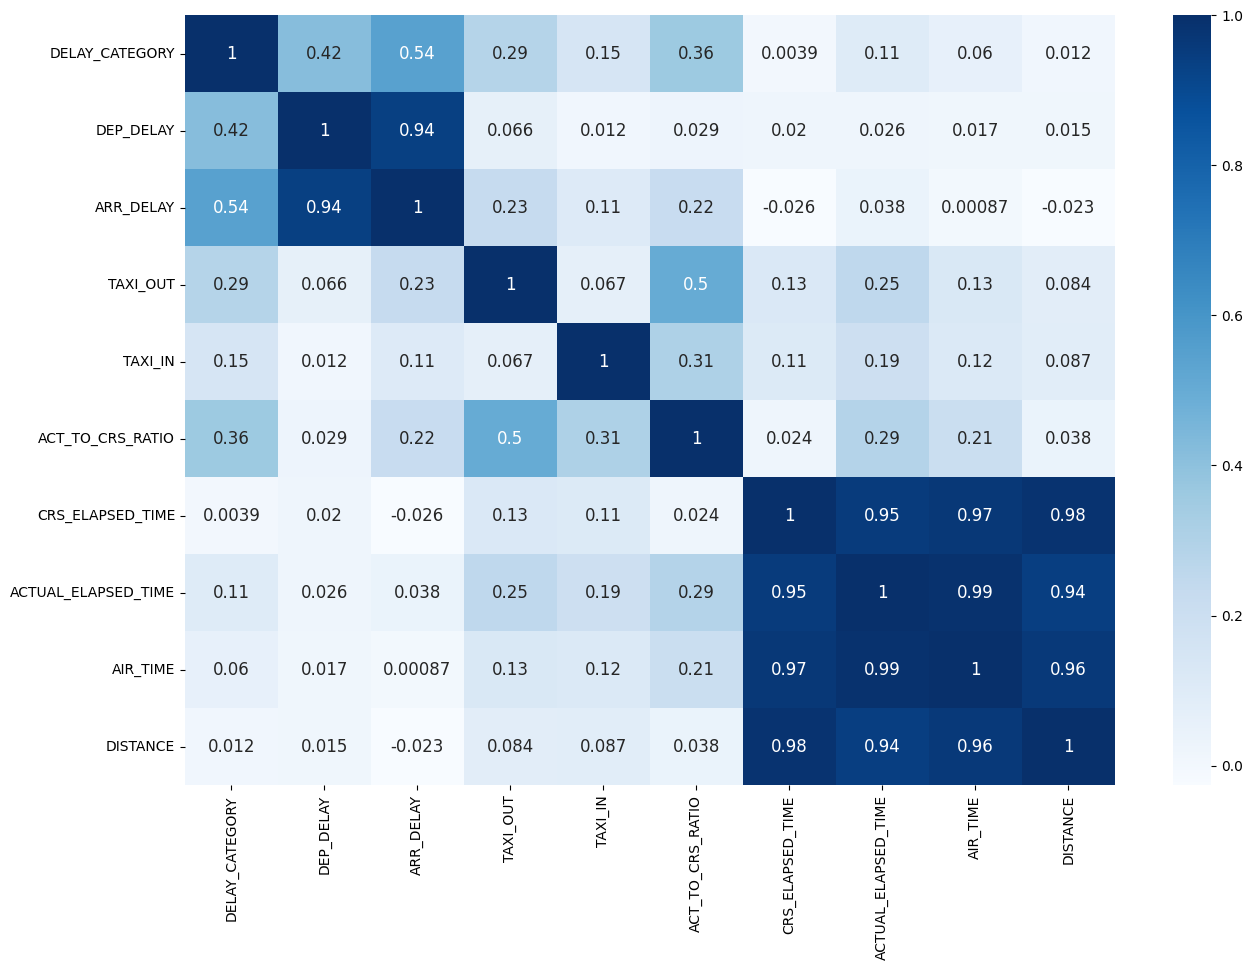

In [11]:
subset_cols = ['DELAY_CATEGORY', 'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ACT_TO_CRS_RATIO','CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE'] 

# Visualizza la heatmap per il sottoinsieme di colonne selezionato
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df[subset_cols].corr(), cmap="Blues", annot=True, annot_kws={"size": 12})

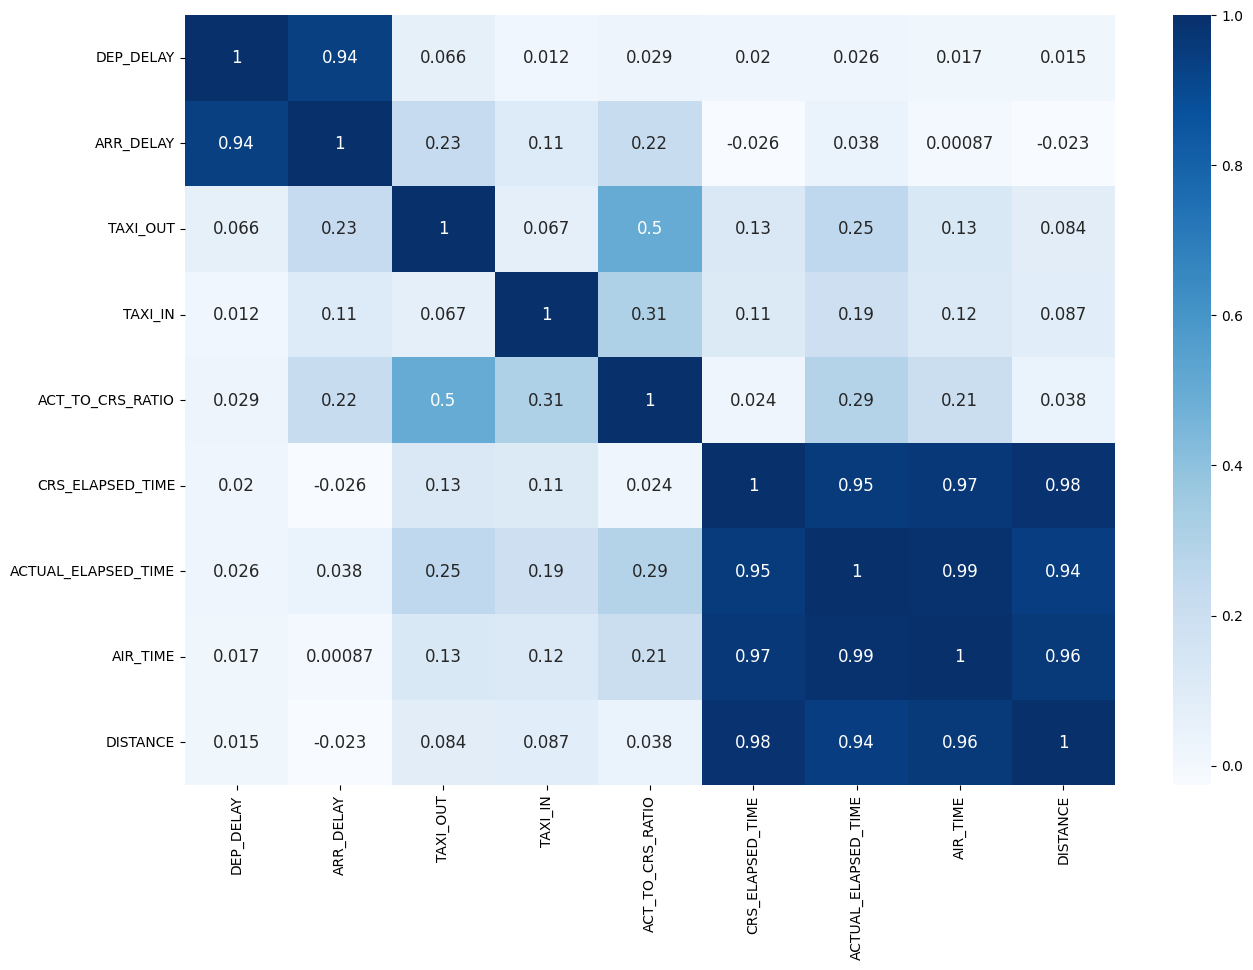

In [13]:
# Visualizza la heatmap per il sottoinsieme di colonne selezionato
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df[subset_cols].drop(columns=['DELAY_CATEGORY']).corr(), cmap="Blues", annot=True, annot_kws={"size": 12})

# Classificazione

In [ ]:
# Questo deve essere usato nella milticlasse
def categorize_delay(row):
    arr_delay = row['ARR_DELAY']
    other_delays = [row['CARRIER_DELAY'], row['WEATHER_DELAY'], row['NAS_DELAY'], row['SECURITY_DELAY'], row['LATE_AIRCRAFT_DELAY']]
    
    # Gestiamo i valori mancanti (NaN)
    if any(pd.isna(delay) for delay in [arr_delay] + other_delays):
        return 'Invalid'
    
    # Se ARR_DELAY è negativo e gli altri ritardi sono tutti >= 0
    if arr_delay < 0 and all(delay == 0 for delay in other_delays):
        return 'Early'
    
    # Se ARR_DELAY è 0 e gli altri ritardi sono tutti 0
    if arr_delay == 0 and all(delay == 0 for delay in other_delays):
        return 'On Time'
    
    # Se ARR_DELAY è positivo, controlliamo i ritardi
    if arr_delay >= 0 and all(delay >= 0 for delay in other_delays):
        if arr_delay <= 30:  # Ritardo basso
            return 'Low Delay'
        elif 31 <= arr_delay <= 60:  # Ritardo medio
            return 'Medium Delay'
        else:  # Ritardo alto
            return 'High Delay'
    
    return 'Invalid'  # Caso in cui ci siano ritardi non validi (negativi tra gli altri ritardi)

# Applichiamo la funzione per creare la colonna di target
df['delay_category'] = df.apply(categorize_delay, axis=1)

In [ ]:
y = df['DELAY_CATEGORY']
x = df.drop(columns=['DELAY_CATEGORY'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [16]:
# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(probability=True),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [ ]:
# ROC curve and AUC for multi-class problems
for i, clf in enumerate(classifiers):
    name = clf.__class__.__name__
    clf_name.append(name)
    
    # Fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    # Accuracy
    acc = round(accuracy_score(y_test, y_pred), 2)
    print(f'Accuracy: {acc} \t ---> {name}')
    
    # Confusion matrix, classification report, ROC curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    
    # For each class in the multi-class case
    y_pred_proba = clf.predict_proba(x_test)  # Get probabilities for each class
    
    # Iterate over all classes (for multi-class ROC curve)
    for class_idx in range(y_pred_proba.shape[1]):
        # ROC curve for each class
        fpr, tpr, thresholds = roc_curve(y_test == class_idx, y_pred_proba[:, class_idx])
        roc_auc_val = auc(fpr, tpr)
        
        # Append ROC and AUC values for each class
        roc_auc.append(roc_auc_val)
        roc_tpr.append(tpr)
        roc_fpr.append(fpr)

# Cross-validation results (unchanged part)
for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.99 	 ---> LogisticRegression


c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Accuracy: 1.0 	 ---> DecisionTreeClassifier


c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
